# Creating a simple neural network in PyTorch

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class SimpleNet(nn.Module):

    def __init__(self, in_dim, out_dim):
        # we do the super init as we want to inherit
        # methods from nn.Module
        super().__init__()

        # this is a layer with out_dim neurons
        self.linear_1 = nn.Linear(in_dim, out_dim)
    def forward(self, x):
        # this function does the forward pass
        # it takes the input and passes it through our layers
        # until it generates an output
        x = self.linear_1(x)
        return x

In [484]:
model = SimpleNet(5, 2)

In [485]:
x = torch.rand((1, 3))

In [487]:
torch.tensor([[1,2,3,4, 0], [1,2, 0, 0, 0]])

ValueError: expected sequence of length 3 at dim 1 (got 2)

In [486]:
model(x)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x3 and 5x2)

In [155]:
# do a test input with torch.zeros
# add activation sigmoid

In [156]:
import numpy as np

In [157]:
x = np.arange(-5,5, 0.001)

In [44]:
import matplotlib.pyplot as plt 
plt.plot(x, F.sigmoid(torch.tensor(x)))

NameError: name 'x' is not defined

In [159]:
# start looking into documentation for nn.Linear
# look into our model and examine layer shapes
# maybe a quick bit about matrix mult and size reqs

In [160]:
model = SimpleNet(5, 1)

In [161]:
model.linear_1.weight.shape

torch.Size([1, 5])

# Doing it from scratch using pytorch tensors

In [162]:
x = torch.rand((1, 5))

In [163]:
x.shape

torch.Size([1, 5])

In [164]:
out_features = 2
in_features = x.shape[1]

In [165]:
linear_layer_1 = torch.rand((out_features, in_features))

In [166]:
linear_layer_1.shape

torch.Size([2, 5])

In [167]:
output = x @ linear_layer_1.T

In [168]:
output

tensor([[1.4879, 1.4028]])

In [169]:
F.sigmoid(output)

tensor([[0.8158, 0.8026]])

# How does a model learn?

In [182]:
y = torch.tensor([1])
y


tensor([1])

In [171]:
criterion = torch.nn.CrossEntropyLoss()

In [172]:
loss = criterion(output, y)

In [173]:
loss

tensor(0.7366)

In [150]:
loss.backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [199]:
x = torch.rand((1, 5), requires_grad=True)
linear_layer_1 = torch.rand((out_features, in_features), requires_grad=True)

In [200]:
output = x @ linear_layer_1.T

In [201]:
output

tensor([[0.3675, 0.1067]], grad_fn=<MmBackward0>)

In [202]:
output = F.sigmoid(output)
output

tensor([[0.5909, 0.5266]], grad_fn=<SigmoidBackward0>)

In [203]:
loss = criterion(output, y)

In [195]:
loss.backward()

In [206]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().item())
            max_grads.append(p.grad.abs().max().item())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    #plt.legend([Line2D([0], [0], color="c", lw=4),
     #           Line2D([0], [0], color="b", lw=4),
       #         Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [213]:
output = model(x)

In [214]:
output = F.sigmoid(output)

In [215]:
loss = criterion(output, y)

In [216]:
loss.backward()

In [222]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-1)

In [224]:
model.linear_1.weight

Parameter containing:
tensor([[ 0.1376,  0.1569, -0.1422, -0.4264,  0.2824],
        [-0.1869,  0.1829,  0.2859,  0.3942, -0.1636]], requires_grad=True)

In [225]:
optimizer.step()

In [226]:
model.linear_1.weight

Parameter containing:
tensor([[ 0.0374,  0.0567, -0.2421, -0.5259,  0.1822],
        [-0.0867,  0.2827,  0.3856,  0.4938, -0.0635]], requires_grad=True)

In [ ]:
# here we do the backpropagation pass graph
# we also need to implement a custom tensor that stores the previous operation
# use the slideshow to give an example of backpropogation

In [420]:
import math

In [595]:
class CustomTensor():
    def __init__(self, data, label, _children=(), _op=''):
        if isinstance(data, torch.Tensor):
            self.data = data
        else:
            self.data = torch.tensor(data, dtype=torch.float, requires_grad=True)
        self.label = label
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
    def __repr__(self):
        return f'{self.label}: {self.data}'
    def __mul__(self, other):
        other = other if isinstance(other, CustomTensor) else CustomTensor(other)
        if self.data.shape[1] != other.data.shape[0]:
            raise RuntimeError('Shapes do not match')
        out = CustomTensor(self.data @ other.data, f'{self.label}*{other.label}',(self, other), '*')

        def _backward():
            #self.grad += other.data @ out.grad.T
            #other.grad += self.data @ out.grad.T
            pass
        out._backward = _backward

        return out
    def sigmoid(self):
        e = torch.exp(self.data)
        out = CustomTensor(F.sigmoid(self.data), 'Sigmoid Out',(self,), "Sigmoid")

        def _backward():

            t = self.data.detach().clone()
            t.requires_grad = True
            torch.sigmoid(t).backward()
            self.grad = t.grad[0].item()
        out._backward = _backward

        return out
    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()
        self.data.backward()

In [596]:
from typing import Any, List
class SimpleCustomLayer:
    def __init__(self, dim_in, dim_out, label):
        # if you rember weight matrix is A.T so we want to rever the dims
        self.weights = CustomTensor(np.random.rand(dim_out, dim_in), label)
    # forward function
    def __call__(self, x):
        return x * self.weights
class SimpleCustomModel():
    def __init__(self, n_layers, dim_in: int, dims_out: [int]):
        self.layers = []
        self.layers.append(SimpleCustomLayer(dims_out[0], dim_in,f'linear_{0}'))
        for n, layer in enumerate(range(n_layers-1)):
            self.layers.append(SimpleCustomLayer(dims_out[n], dims_out[n+1], f'linear_{n+1}'))
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x.sigmoid()

In [597]:
x = CustomTensor(np.random.rand(1,5), label='X')

In [598]:
model = SimpleCustomModel(1, 5, [1])

In [599]:
output = model(x)

In [600]:
output.backward()

In [601]:
from graphviz import Digraph

In [604]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        
        dot.node(name=str(id(n)), label = f"{n.label} | Grad: {n.data.grad if n.data.grad is not None else n.grad}", shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

/var/folders/nb/x8ft0wb94sd72p6bpk_ld9fc0000gn/T/ipykernel_14576/1517734235.py:23: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  dot.node(name=str(id(n)), label = f"{n.label} | Grad: {n.data.grad if n.data.grad is not None else n.grad}", shape='record')


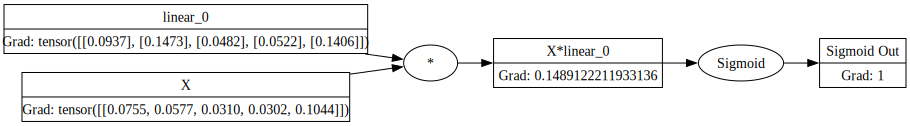

In [605]:
draw_dot(output)

In [612]:
0.6293 * 0.1489122

0.09371044746

In [611]:
x

X: tensor([[0.6293, 0.9890, 0.3239, 0.3502, 0.9440]], requires_grad=True)

# A visual example of a model training on an MNIST dataset

In [7]:
from torchvision import datasets, transforms

In [8]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

In [9]:
dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 8549784.24it/s] 


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 231585.57it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2546571.17it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2548906.71it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [12]:
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=32)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=32)

In [71]:
# source: https://github.com/pytorch/examples/blob/main/mnist/main.py
class MidNet(nn.Module):
    def __init__(self):
        super(MidNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc = nn.Sequential(nn.Linear(9216, 128),
                                nn.ReLU(),
                                nn.Linear(128, 10))

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        output = F.log_softmax(x, dim=1)
        return output

In [72]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc = nn.Sequential(nn.Linear(9216, 128))
        for i in range(50):
            self.fc.append(nn.Linear(128,128))
            self.fc.append(nn.ReLU())
        self.fc.append(nn.Linear(128,10))

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        output = F.log_softmax(x, dim=1)
        return output

In [144]:
def train(model, device, train_loader, optimizer, is_tracking_grad=False):
    model.train()
    losses = []
    grads = []
    for i in range(20):
        for batch_idx, (data, target) in enumerate(train_loader):
            grads_ = []
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            if is_tracking_grad:
                for i in range(len(model.fc)):
                    if isinstance(model.fc[i], nn.Linear):
                        # to not affect the gradient
                        with torch.no_grad():
                            grads_.append(torch.sum(model.fc[i].weight.grad).item())
            optimizer.step()
            losses.append(loss.item())
            grads.append(grads_)
    return (losses, grads)

In [145]:
model_mid = MidNet().to('mps')
model_large = LargeNet().to('mps')

In [146]:
optimizer_mid = torch.optim.AdamW(model_mid.parameters(), lr=1e-3)
optimizer_large = torch.optim.AdamW(model_large.parameters(), lr=1e-3)

In [147]:
losses_mid = train(model_mid, 'mps', train_loader, optimizer_mid, True)
losses_large = train(model_large, 'mps', train_loader, optimizer_large, True)

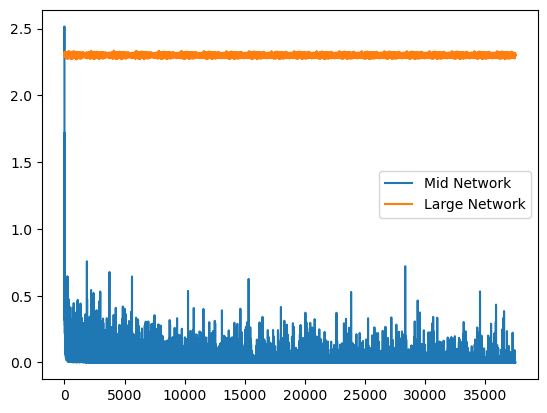

In [148]:
plt.plot(losses_mid[0], label='Mid Network')
plt.plot(losses_large[0], label='Large Network')
plt.legend()

In [104]:
import numpy as np

In [149]:
gradients_mid = np.array(losses_mid[1])

In [113]:
(9216*118) / (118*10)

921.6

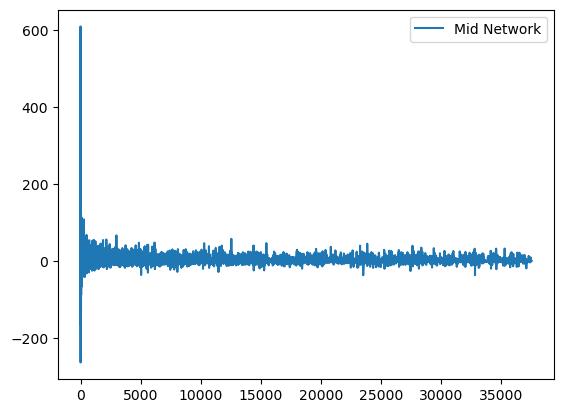

In [152]:
plt.plot(gradients_mid[:,0], label='Mid Network')
#plt.plot(gradients_mid[:,0], label='Large Network')
plt.legend()

In [153]:
gradients_large = np.array(losses_large[1])

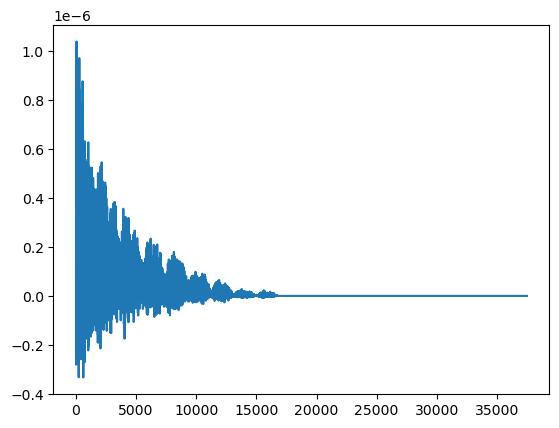

In [155]:
plt.plot(gradients_large[:,-1])

In [159]:
class ResidualNet(nn.Module):
    def __init__(self):
        super(ResidualNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128,128)
        self.fc = nn.Sequential()
        for i in range(50):
            self.fc.append(nn.Linear(128,128))
            self.fc.append(nn.ReLU())
        
        self.fc3 = nn.Linear(128,10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        for f in self.fc:
            x = x + f(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output
        

In [160]:
model_residual = ResidualNet().to('mps')
optimizer_residual = torch.optim.AdamW(model_residual.parameters(), lr=1e-3)

In [161]:
losses, grads_res = train(model_residual, 'mps', train_loader, optimizer_residual, True)

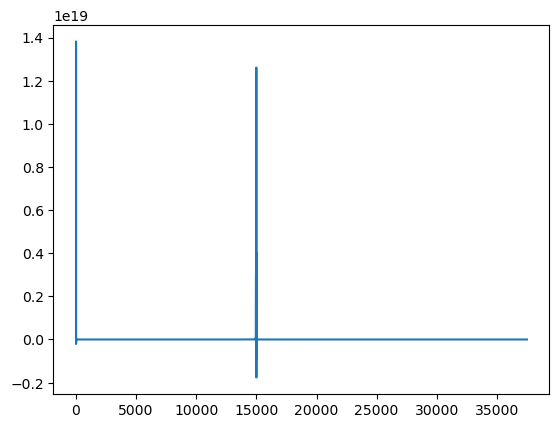

In [167]:
plt.plot(np.array(grads_res)[:,-1])